In [1]:
import numpy as np  # 科学计算工具包
import pandas as pd  # 数据分析工具包
import matplotlib.pyplot as plt # 图表绘制工具包
import seaborn as sns # 基于 matplot, 导入 seaborn 会修改默认的 matplotlib 配色方案和绘图样式，这会提高图表的可读性和美观性
import os,pymysql
from sqlalchemy import create_engine # 数据库

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

# 在 jupyter notebook 里面显示图表
%matplotlib inline


In [2]:
table_list= [filename for filename in os.listdir('.') if filename.endswith('.csv') ]
print(table_list)

['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']


## 获取数据集

In [10]:
orders = pd.read_csv("olist_orders_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
seller = pd.read_csv("olist_sellers_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")
pro_trans = pd.read_csv("product_category_name_translation.csv")

##  理解数据集

In [11]:
# 合并表
order_payment = pd.merge(orders,payments, on='order_id',how='left')
payorder_customer =  pd.merge(order_payment,customers, on='customer_id',how='left')
basic_data = pd.merge(payorder_customer,order_items, on='order_id',how='left')

basic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   payment_sequential             118431 non-null  float64
 9   payment_type                   118431 non-null  object 
 10  payment_installments           118431 non-null  float64
 11  payment_value                  118431 non-null  float64
 12  customer_unique_id            

## 清洗数据集

### 缺失值处理

In [12]:
# 预览数据集

basic_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,...,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,...,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [123]:

def missing_info(data,num):
    # func:统计缺失值数量和占比函数
    # data: dataframe类型
    # num: 数字类型，显示前几行数据
    # return: 缺失值统计\占比

    null_data = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()
    missing_data = pd.concat([null_data,percent_1.apply(lambda x: format(x, '.2%'))],axis=1,keys=['total missing','missing percentage'])
    print(missing_data.head(num))

missing_info(basic_data,15)

                               total missing missing percentage
order_yearmonth                            0              0.00%
order_date                                 0              0.00%
customer_id                                0              0.00%
order_status                               0              0.00%
order_purchase_timestamp                   0              0.00%
order_approved_at                          0              0.00%
order_delivered_carrier_date               0              0.00%
order_delivered_customer_date              0              0.00%
order_estimated_delivery_date              0              0.00%
payment_sequential                         0              0.00%
payment_type                               0              0.00%
payment_installments                       0              0.00%
payment_value                              0              0.00%
customer_unique_id                         0              0.00%
customer_zip_code_prefix                

缺失值处理：
- order_delivered_customer_date、order_delivered_carrier_date 字段缺失值数量分别为3229，2074，相对其他缺失数据较多，但是占整体数据较少仅 2.87%，1.75%，，可直接删除缺失值。
- 其他字段的缺失值与整体数据相比就更少了，亦可删除。


In [21]:
# 删除缺失值
basic_data = basic_data.dropna()
basic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115018 non-null  object 
 1   customer_id                    115018 non-null  object 
 2   order_status                   115018 non-null  object 
 3   order_purchase_timestamp       115018 non-null  object 
 4   order_approved_at              115018 non-null  object 
 5   order_delivered_carrier_date   115018 non-null  object 
 6   order_delivered_customer_date  115018 non-null  object 
 7   order_estimated_delivery_date  115018 non-null  object 
 8   payment_sequential             115018 non-null  float64
 9   payment_type                   115018 non-null  object 
 10  payment_installments           115018 non-null  float64
 11  payment_value                  115018 non-null  float64
 12  customer_unique_id            

### 异常值处理

In [22]:
# 观察数据异常情况

basic_data.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value
count,115018.000000,115018.000000,115018.000000,115018.000000,115018.000000,115018.000000,115018.000000
mean,1.090699,2.936958,171.915654,35081.609113,1.196404,120.080129,19.995686
std,0.684409,2.772466,266.125730,29851.527722,0.699409,183.038922,15.744372
min,1.000000,0.000000,0.000000,1003.000000,1.000000,0.850000,0.000000
25%,1.000000,1.000000,60.850000,11310.000000,1.000000,39.900000,13.080000
50%,1.000000,2.000000,108.190000,24320.000000,1.000000,74.900000,16.280000
75%,1.000000,4.000000,188.940000,58801.750000,1.000000,133.000000,21.180000
max,26.000000,24.000000,13664.080000,99980.000000,21.000000,6735.000000,409.680000


异常值情况\

- payment_installments 最小值为0    
   - 付款要么一次性付清，要么分期付款，而分期付款一般有3、6、12、24期等。
   - 分期付款期数为1时，说明用户是一次性付清，没有分期。所以这里为0是异常值
- payment_value 最小值为0
   - 支付金额为0的情况有点异常，但不排除是使用代金券或者礼品卡。需要查询详细数据。


In [25]:
# 查询异常值的详细数据 payment_installments

basic_data[basic_data['payment_installments']==0].T

,75796,78915,78916
order_id,744bade1fcf9ff3f31d860ace076d422,1a57108394169c0b47d8f876acc9ba2d,1a57108394169c0b47d8f876acc9ba2d
customer_id,5e5794daaa13f73e2f1cdb4114529843,48ebb06cf56dba9d009230cc751bb195,48ebb06cf56dba9d009230cc751bb195
order_status,delivered,delivered,delivered
order_purchase_timestamp,2018-04-22 11:34:42,2018-05-15 16:25:14,2018-05-15 16:25:14
order_approved_at,2018-04-24 19:04:46,2018-05-15 16:36:52,2018-05-15 16:36:52
order_delivered_carrier_date,2018-04-24 03:14:34,2018-05-17 12:37:00,2018-05-17 12:37:00
order_delivered_customer_date,2018-04-27 20:55:28,2018-05-24 15:45:41,2018-05-24 15:45:41
order_estimated_delivery_date,2018-05-16 00:00:00,2018-06-06 00:00:00,2018-06-06 00:00:00
payment_sequential,2,2,2
payment_type,credit_card,credit_card,credit_card


可以看出，异常数据的支付金额不为0，并使用借记卡进行支付，但分期付款期数为0，明显矛盾，删除这类异常值

In [26]:
# 查询异常值的详细数据 payment_installments

basic_data[basic_data['payment_value']==0].T

,503,38539,102033,115449
order_id,45ed6e85398a87c253db47c2d9f48216,6ccb433e00daae1283ccc956189c82ae,b23878b3e8eb4d25a158f57d96331b18,8bcbe01d44d147f901cd3192671144db
customer_id,8eab8f9b3c744b76b65f7a2c0c8f2d6c,843b211abe7b0264dd4a69eafc5bdf43,648121b599d98c420ef93f6135f8c80c,f2def7f64f36952f2f5a9791f0285f34
order_status,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-06-08 21:18:45,2017-10-26 23:51:35,2017-05-27 19:20:24,2018-01-24 23:24:14
order_approved_at,2017-06-08 21:30:18,2017-10-27 00:46:58,2017-05-27 19:35:17,2018-01-24 23:37:20
order_delivered_carrier_date,2017-06-09 08:35:18,2017-10-27 19:53:03,2017-05-29 04:49:37,2018-01-30 22:43:30
order_delivered_customer_date,2017-06-22 17:44:53,2017-11-08 18:47:00,2017-06-07 08:53:10,2018-02-02 21:26:42
order_estimated_delivery_date,2017-07-10 00:00:00,2017-11-22 00:00:00,2017-06-29 00:00:00,2018-02-21 00:00:00
payment_sequential,3,4,4,4
payment_type,voucher,voucher,voucher,voucher


In [29]:
#删除异常值

basic_data= basic_data.drop(basic_data[basic_data['payment_installments']==0].index)
basic_data.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value
count,115015.000000,115015.000000,115015.000000,115015.000000,115015.000000,115015.000000,115015.000000
mean,1.090675,2.937034,171.917368,35081.713272,1.196400,120.082137,19.995692
std,0.684403,2.772461,266.128934,29851.764382,0.699414,183.040887,15.744557
min,1.000000,1.000000,0.000000,1003.000000,1.000000,0.850000,0.000000
25%,1.000000,1.000000,60.850000,11310.000000,1.000000,39.900000,13.080000
50%,1.000000,2.000000,108.190000,24320.000000,1.000000,74.900000,16.280000
75%,1.000000,4.000000,188.940000,58803.000000,1.000000,133.000000,21.180000
max,26.000000,24.000000,13664.080000,99980.000000,21.000000,6735.000000,409.680000


In [30]:
# 查看数据的信息
basic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115015 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115015 non-null  object 
 1   customer_id                    115015 non-null  object 
 2   order_status                   115015 non-null  object 
 3   order_purchase_timestamp       115015 non-null  object 
 4   order_approved_at              115015 non-null  object 
 5   order_delivered_carrier_date   115015 non-null  object 
 6   order_delivered_customer_date  115015 non-null  object 
 7   order_estimated_delivery_date  115015 non-null  object 
 8   payment_sequential             115015 non-null  float64
 9   payment_type                   115015 non-null  object 
 10  payment_installments           115015 non-null  float64
 11  payment_value                  115015 non-null  float64
 12  customer_unique_id            

### 重复值处理

In [31]:
# 查看每一行数据是否存在重复值

basic_data.duplicated().sum()

0

没有重复值，不需要进行处理。

### 数据类型转化

In [35]:
# 日期时间数据类型转化的函数

def transform_datetime(data,column_list):
    # func: 日期时间字符串转化函数
    # data: dataframe类型
    # num: 数字类型，显示前几行数据
    # return: 日期时间类型数据

    for i in column_list:
        data[i] = pd.to_datetime(data[i])
    print('日期时间数据类型转化完成')

data = basic_data
column_list =['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'] 
transform_datetime(data,column_list)

日期时间数据类型转化完成


数据清洗后

- 样本大小：115015 条数据
- 字段：22个
- 有少量缺失值，已删除
- 有少量异常值,已删除
- 无重复值

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115015 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115015 non-null  object        
 1   customer_id                    115015 non-null  object        
 2   order_status                   115015 non-null  object        
 3   order_purchase_timestamp       115015 non-null  datetime64[ns]
 4   order_approved_at              115015 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115015 non-null  datetime64[ns]
 6   order_delivered_customer_date  115015 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115015 non-null  datetime64[ns]
 8   payment_sequential             115015 non-null  float64       
 9   payment_type                   115015 non-null  object        
 10  payment_installments           115015 non-null  float64       
 11  

## 导出到数据库



In [41]:
# 导出到 mysql 数据库的函数

def export_mysql(data,user,password,host_port,db,table_name):
    # func: 导出到 mysql 数据库函数
    # data: Dataframe 类型
    # user: 用户名
    # password: 密码
    # host_port: 主机，端口
    # db: 数据库名
    # table_name: 表名

    print('将清洗后的数据导出到 mysql')
    engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(user, password, host_port, db))
    con = engine.connect()#创建连接
    data.to_sql(table_name,engine,if_exists='replace',index=False)
    print('成功导出')

user = 'root'
password = '111111'
host_port = '127.0.0.1:3306'
db = 'Olist'

data = basic_data
table_name = 'basic_data'

export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115015 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115015 non-null  object        
 1   customer_id                    115015 non-null  object        
 2   order_status                   115015 non-null  object        
 3   order_purchase_timestamp       115015 non-null  datetime64[ns]
 4   order_approved_at              115015 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115015 non-null  datetime64[ns]
 6   order_delivered_customer_date  115015 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115015 non-null  datetime64[ns]
 8   payment_sequential             115015 non-null  float64       
 9   payment_type                   115015 non-null  object        
 10  payment_installments           115015 non-null  float64       
 11  

In [43]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


## 分析视角:人-客户
- 分析对象：客户
- 分析模块:
1. 模块一：基础属性
   - 客户地理分布情况
   - 城市购买力排名
2. 模块二：行为偏好
   - 各时段订单量和销售额分布
   - 各工作日订单量和销售额分布
   - 客户付款方式偏好
   - 客户购物时间偏好
3. 模块三：交易属性
   - 新老客户数占比
   - RFM 客户价值分层


### 模块一:基础属性

客户地理位置分布情况

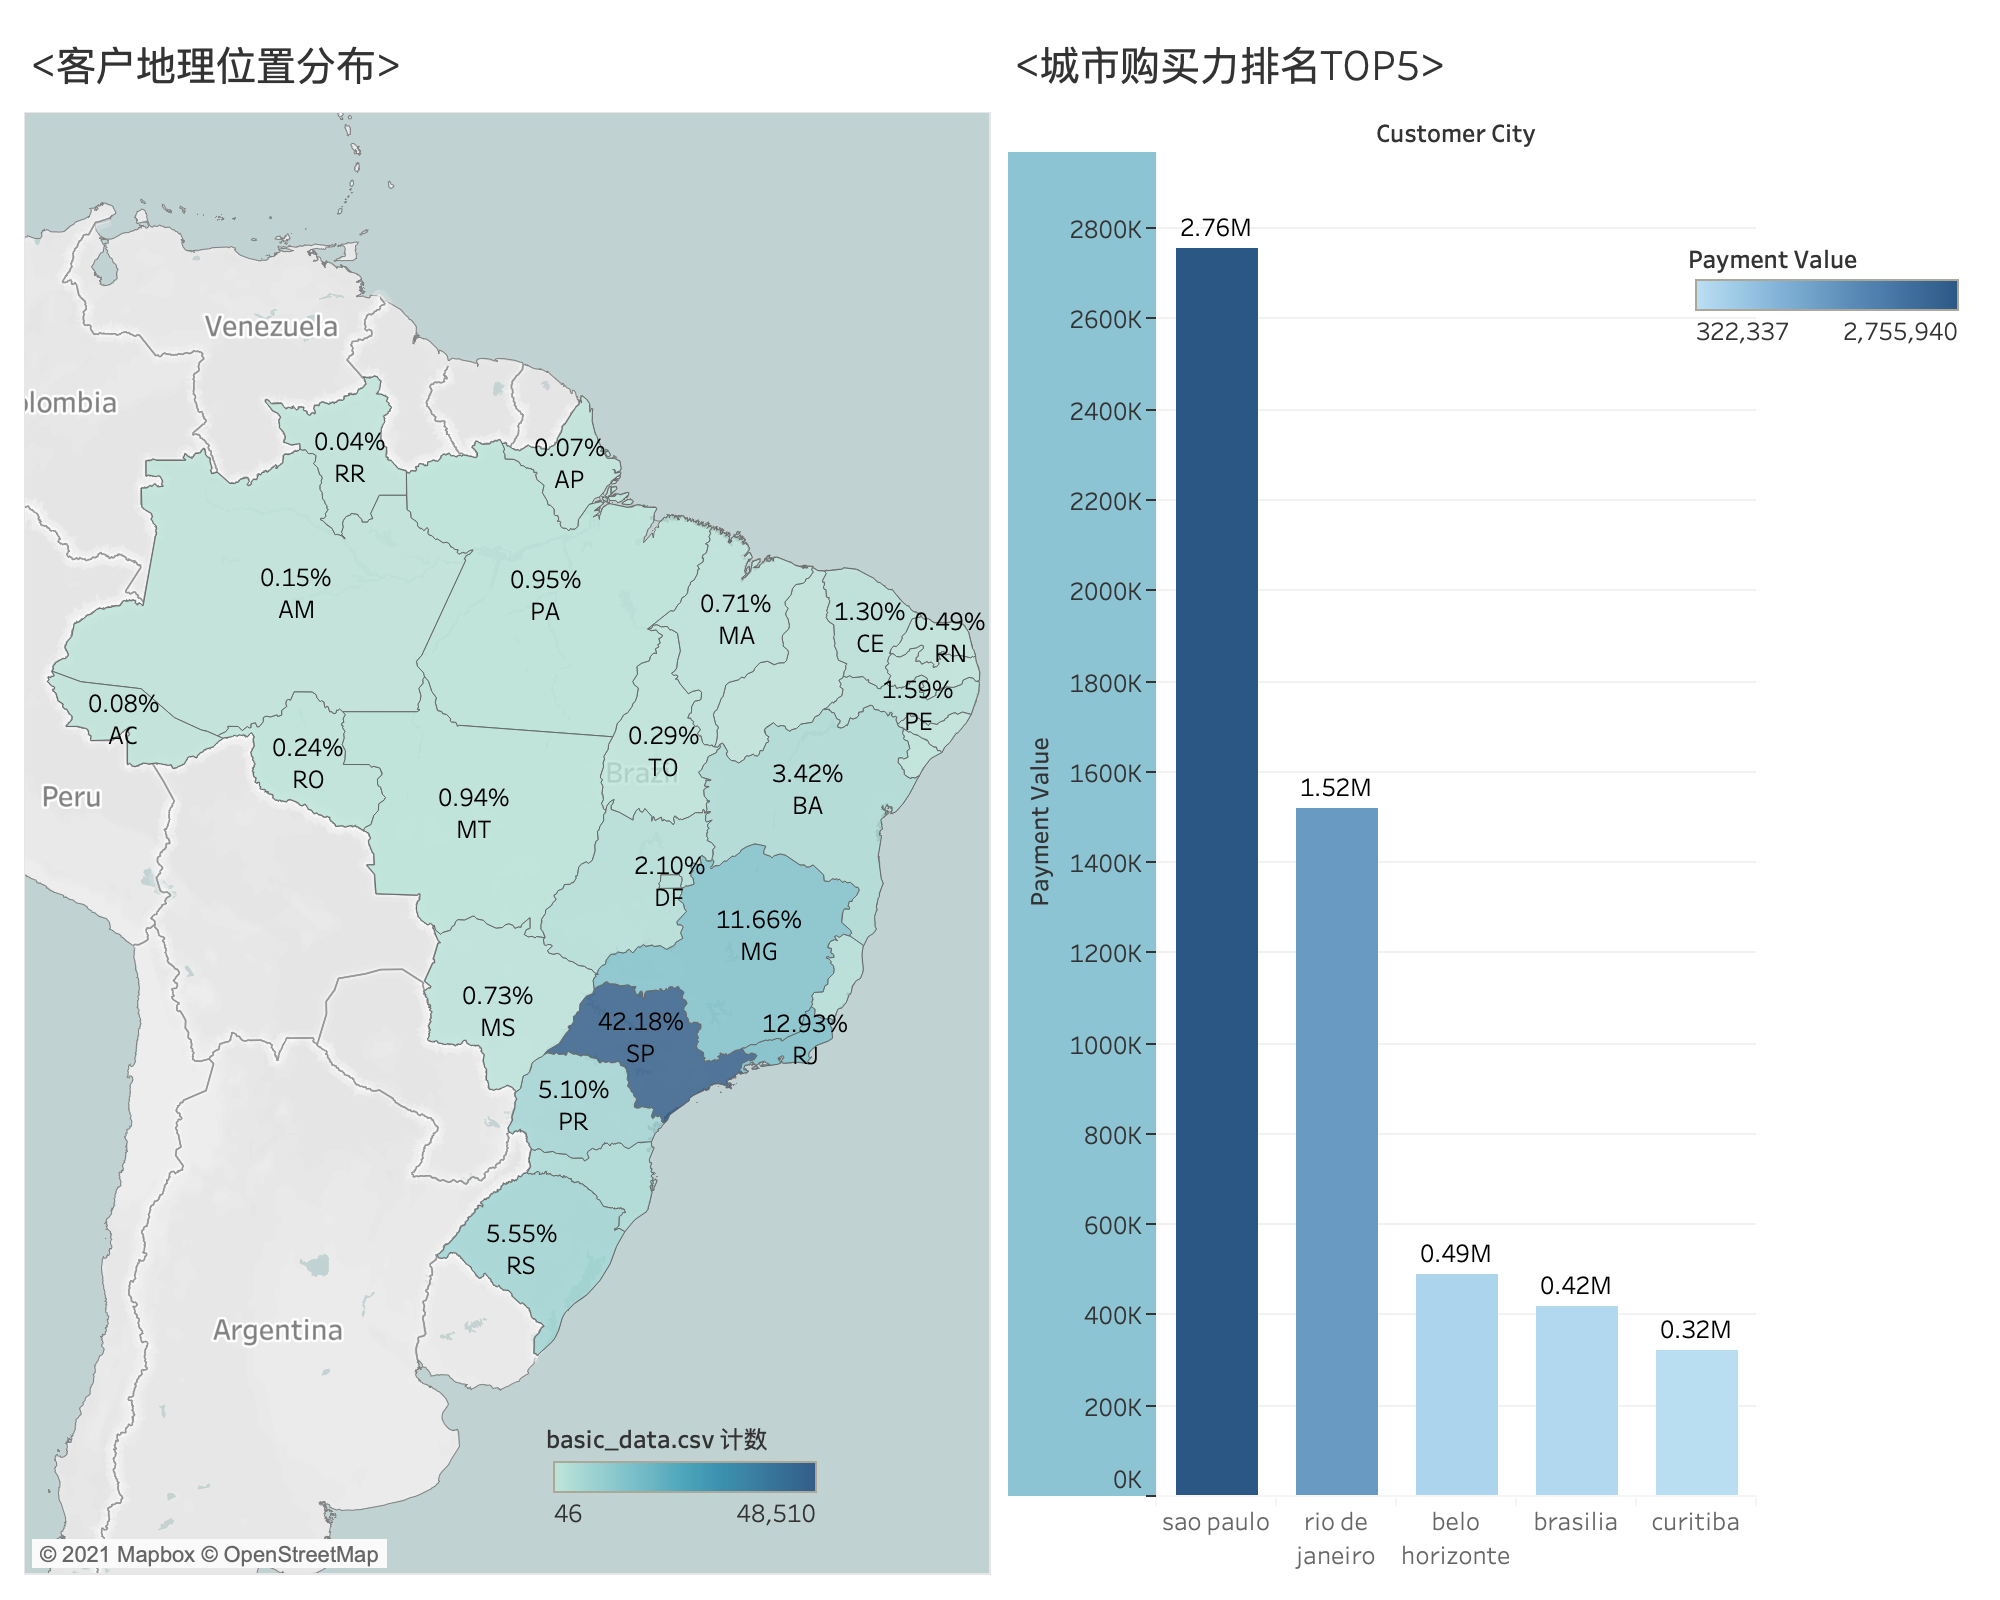

Olist 客户主要集中在7个州和9个城市，巴西圣保罗州(SP)、里约热内卢州(RJ)、米纳斯吉拉斯州(MG)这三个州的客户数处于前列。其中，巴西圣保罗州(SP)是客户数最多的州，占总客户数的 41.18%，而客户数分布最多的城市是巴西圣保罗州的 sao paulo(圣保罗) \
\
购买力排名的前三强为 sao paulo(圣保罗)，rio de janeiro(里约热内卢)，belo horizonte(贝洛奥里藏特)

### 模块二:行为偏好

#### 客户购物偏好

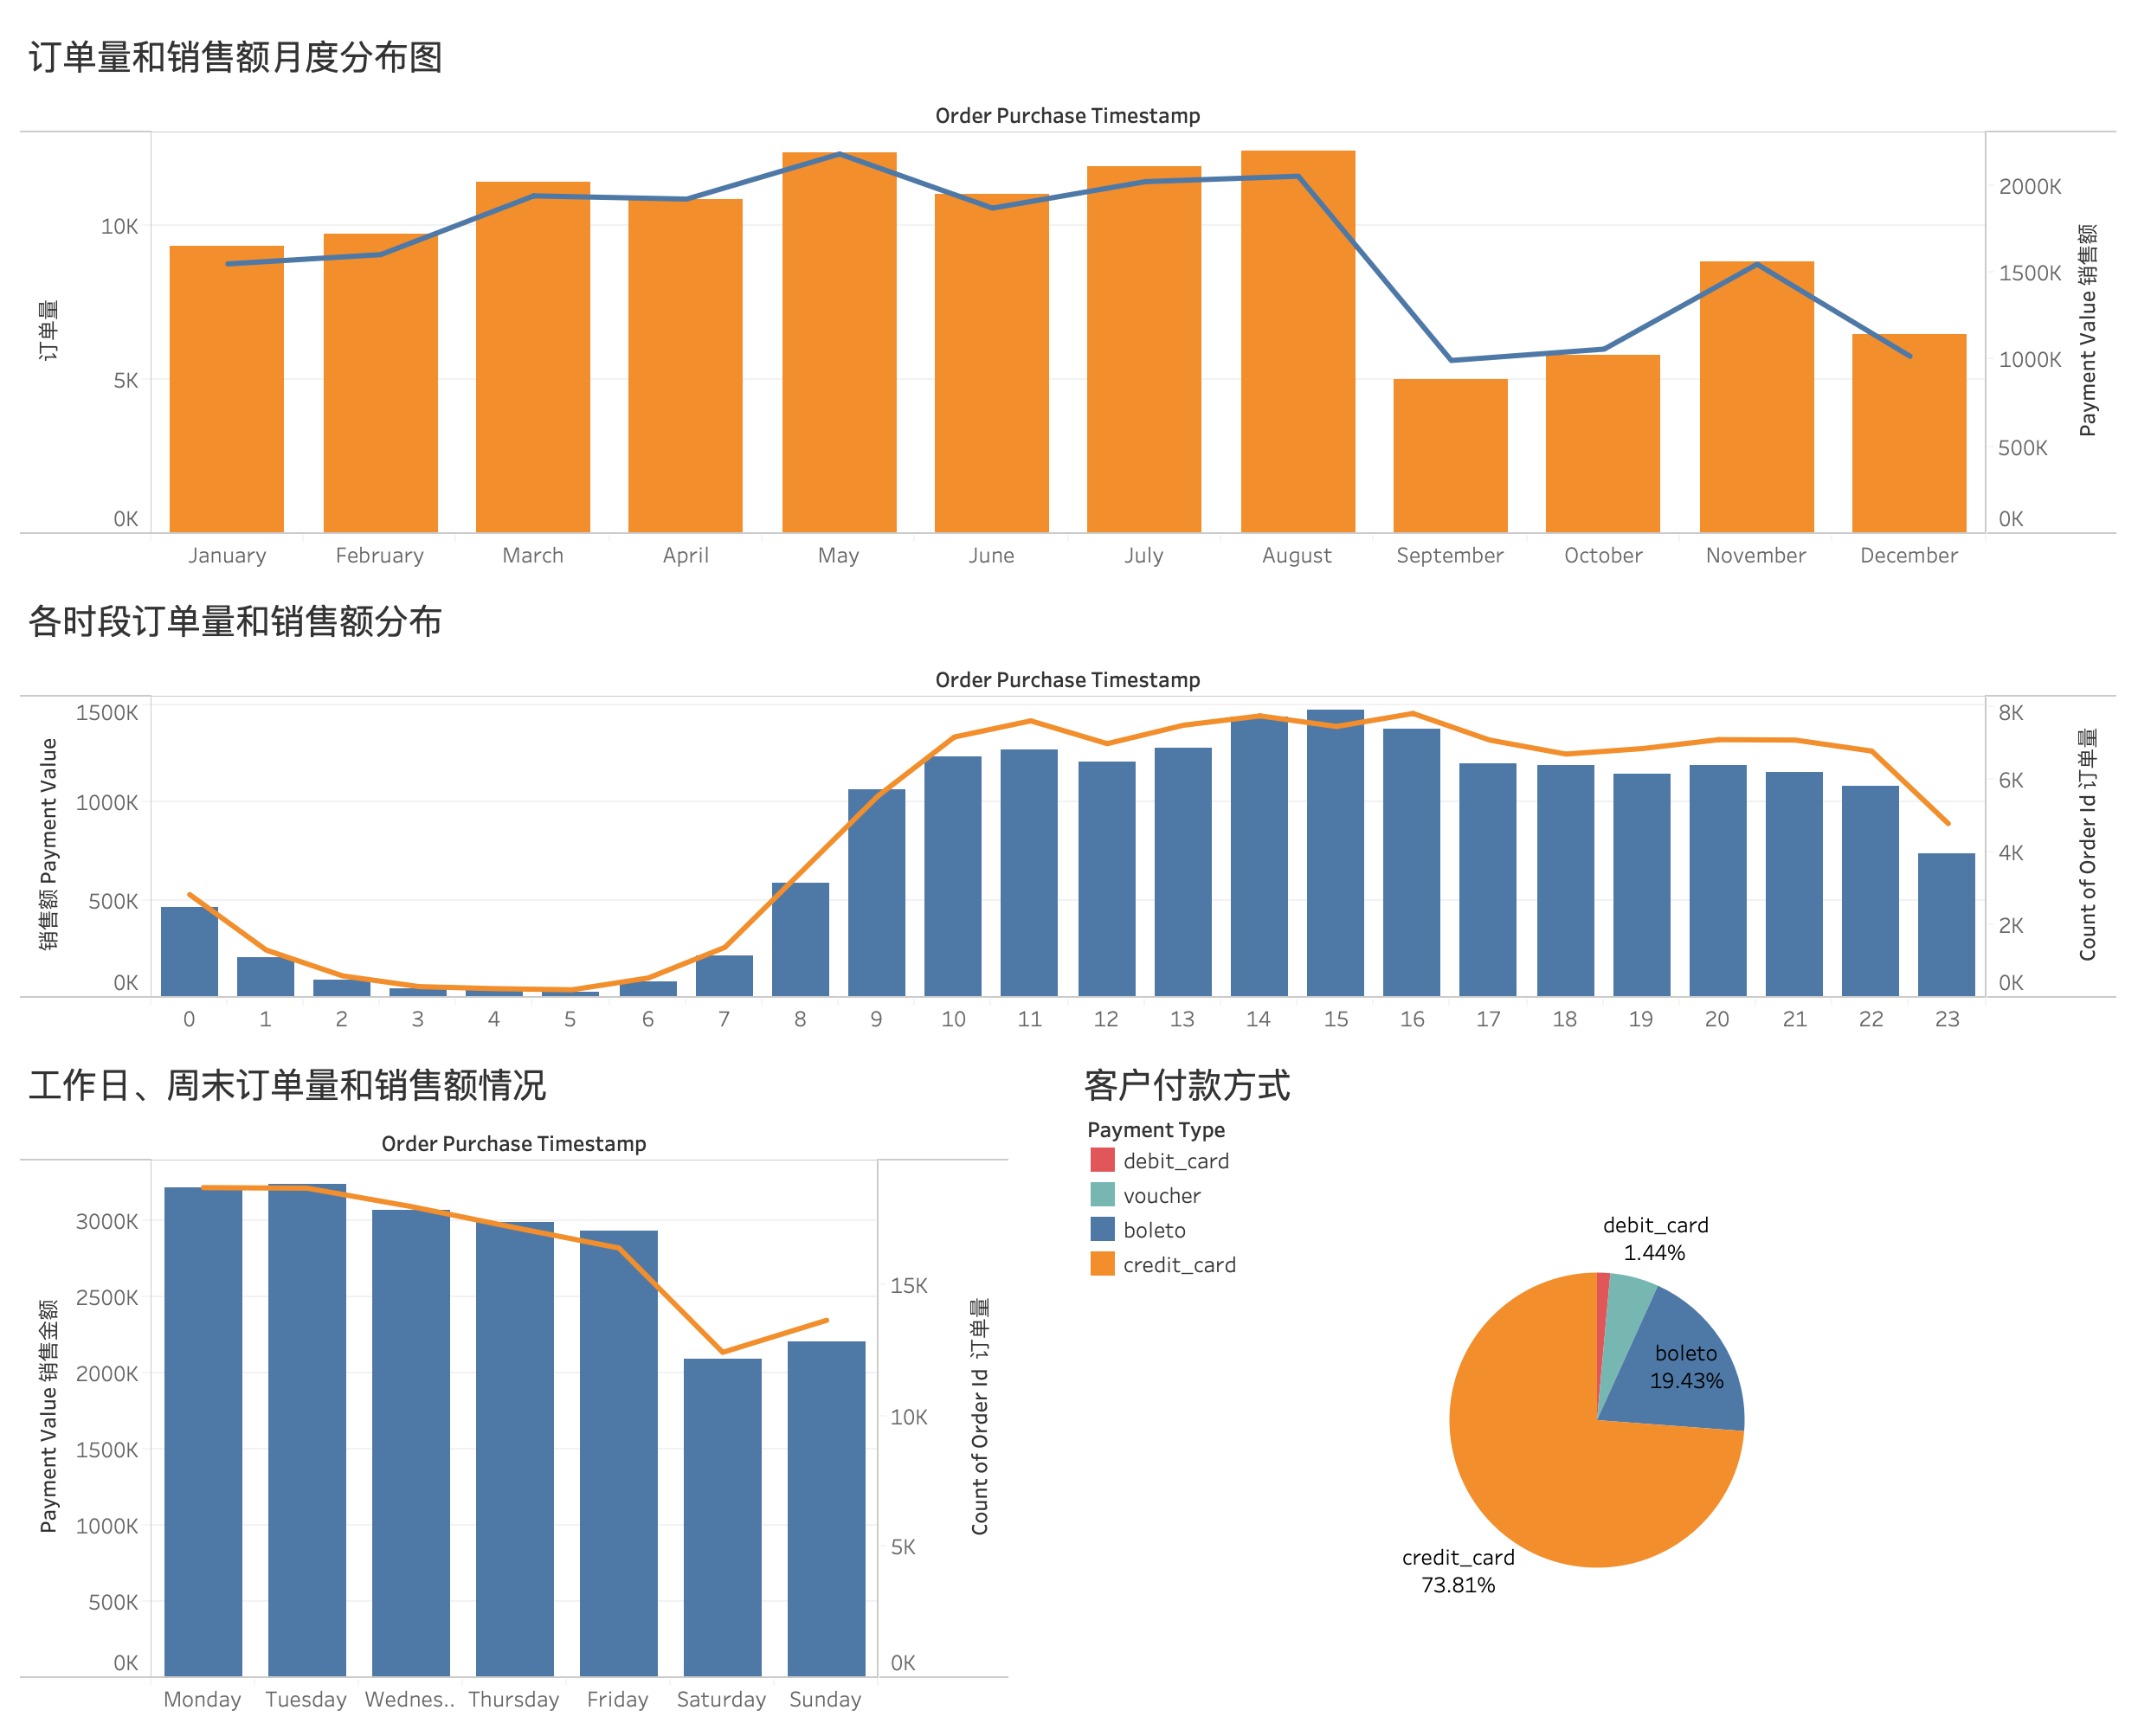

#### 客户购物时间偏好
- 1-8月总体呈上升趋势,但在9月出现下滑,猜测可能因为天气或其他原因
- 用户下单时间大部分为早上9点至晚上22点,夜间下单数量明显降低
- 平日订单量及销售金额明显优于周末,可见周末大家的欲望并不高


#### 付款方式偏好
- 73%的客户选择信用卡付款,线下付款次之比例接近20%





### 模块三:交易属性
- 新老客户占比
- 客户消费行为分析
- RFM 客户价值分层


#### 新老客户占比


In [52]:
# 新增字段：购买日期，购买年月

basic_data['order_date'] = basic_data['order_purchase_timestamp'].dt.date
basic_data['order_yearmonth'] = basic_data['order_purchase_timestamp'].dt.to_period('M')

# 客户首次购买时间和最近一次购买时间

user_life = basic_data.groupby('customer_unique_id',as_index=False).order_date.agg([min,max])
user_life.head(5)

,min,max
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07
0000f46a3911fa3c0805444483337064,2017-03-10,2017-03-10
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,2017-10-12
0004aac84e0df4da2b147fca70cf8255,2017-11-14,2017-11-14


In [56]:
# 查询只进行过一次购买的客户数
new_old = (user_life['min'] == user_life['max']).value_counts(normalize=True)
new_old

True     0.978423
False    0.021577
dtype: float64

从客户数可以看出，新客户数占总客户数97.8%，老客户数占总客户数2.2,大部分客户只购买一次，说明该电商平台在老客户维系工作方面没有到位，亟需改善。

#### RFM模型


- R（Recency）：客户最近一次交易时间的间隔。R值越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。
- F（Frequency）：客户在最近一段时间内交易的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
- M（Monetary）：客户在最近一段时间内交易的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。

In [57]:
# 获取指标
rfm_table=pd.pivot_table(basic_data,index=["customer_unique_id"],values=['order_purchase_timestamp',"order_id","payment_value"],aggfunc={"order_purchase_timestamp":"max","order_id":"count","payment_value":"sum"})
rfm_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93339 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  93339 non-null  int64         
 1   order_purchase_timestamp  93339 non-null  datetime64[ns]
 2   payment_value             93339 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.8+ MB


In [58]:
rfm_table

,order_id,order_purchase_timestamp,payment_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,27.19
0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,43.62
0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,2017-06-08 21:00:36,4134.84
fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,84.58
ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,112.46


### R值
\
R值最近一次消费时间表示用户最近一次消费距离统计时间，消费时间越近的客户价值越大。所以要将 order_purchase_timestamp 里面具体的日期变成R中的天数。
\
假设统计时间是数据中日期时间最大那天

In [67]:
rfm_table ['R'] = (rfm_table['order_purchase_timestamp'].max() -  rfm_table['order_purchase_timestamp'])
rfm_table ['R'] = rfm_table['R'].map(lambda x:x.days) 
rfm_table

### F值、M值
再将 order_id 和 order_total 重命名为F、M



In [76]:
# 为了助于理解，对字段进行更名处理
rfm_table.rename(columns = {
    'payment_value':'M',
    'order_id':'F'
},inplace = True)


In [78]:
rfm = rfm_table[["R","F","M"]]
rfm

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
0000f46a3911fa3c0805444483337064,536,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62
0004aac84e0df4da2b147fca70cf8255,287,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84
fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58
ffff371b4d645b6ecea244b27531430a,567,1,112.46


### 确定分层基线
观察R、F、M的分布情况，找到合适的基线对R、F、M 进行分层

In [79]:
# 观察数据基本情况
rfm.describe()

,R,F,M
count,93339.000000,93339.000000,93339.000000
mean,236.925101,1.232229,211.841525
std,152.577685,0.819828,642.226549
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,63.750000
50%,218.000000,1.000000,112.950000
75%,345.000000,1.000000,201.740000
max,694.000000,75.000000,109312.640000


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='M'>

<Figure size 720x360 with 0 Axes>

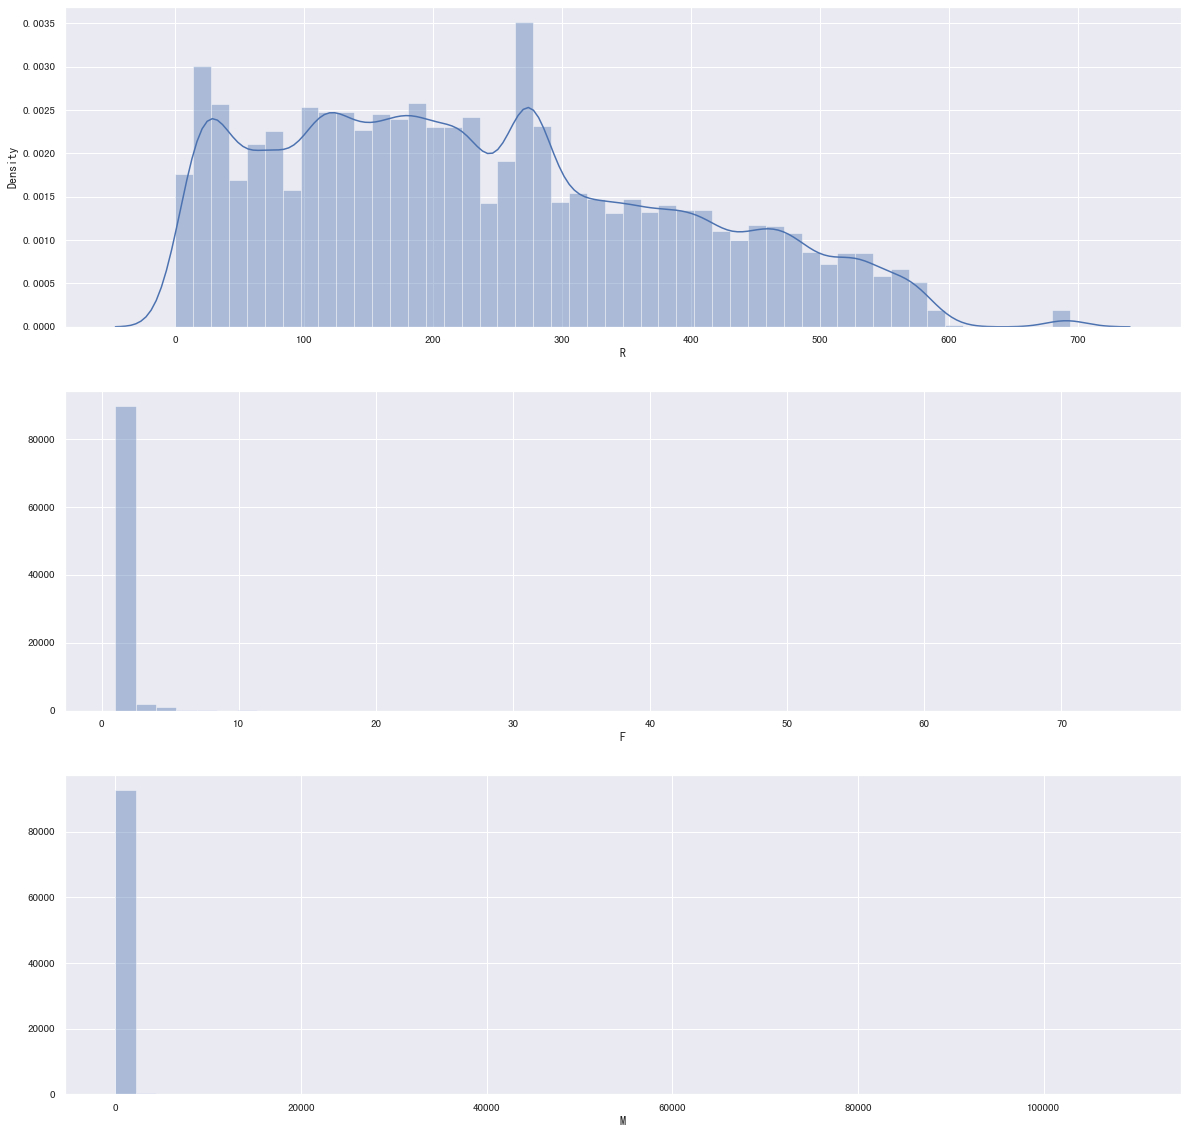

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

fig,axes=plt.subplots(3,1,figsize=(20, 20)) #创建一个一行三列的画布
sns.distplot(rfm['R'],ax=axes[0]) #左图
sns.distplot(rfm['F'],kde=False,ax=axes[1]) #中图
sns.distplot(rfm['M'],kde=False,ax=axes[2]) #右图

从上可得

- R值采用中位数进行划分
- F值存在很严重的偏态分布，F的数值大多集中在1，即消费频次只有1次，至少占整体75%,最大值为75。无法使用分位数方法来均分出2个等级，为了体现出区分度，这里使用自定义区间 bins= [1,75] 进行划分。
- M值存在很严重的偏态分布，75%的M数值小于201.74，最大值为 109312.64，这里使用四分之三位数进行划分。

- R
 - 基线
   - 中位数
 - 规则
   - 高于基线为0(低纬度)
   - 低于基线为1(高纬度)
- F
 - 基线
   - [1,75]
 - 规则
   - 高于基线为1(高纬度)
   - 低于基线为0(低纬度)
- M
 - 基线
   - 四分位数
 - 规则
   - 高于基线为1(高纬度)
   - 低于基线为0(低纬度)


In [82]:
# 对 R、F、M 划分
rfm['r_quartile'] = pd.qcut(rfm['R'], 2, labels=['1','0'])
rfm['f_quartile'] = pd.cut(rfm['F'], bins=[0,1,75], labels=['0','1'])
rfm['m_quartile'] = pd.qcut(rfm['M'], [0,0.75,1], labels=['0','1'])

# 计算出 RFM 的总分
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,R,F,M,r_quartile,f_quartile,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,0,0,100
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,0,0,100
0000f46a3911fa3c0805444483337064,536,1,86.22,0,0,0,000
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,0,0,0,000
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,0,0,0,000


In [83]:
# RFM 总分映射为八类客户
customer_classification = {
"111":"重要价值客户",
"011":"重要保持客户",
"101":"重要发展客户",
"001":"重要挽留客户",
"110":"一般价值客户",
"010":"一般保持客户",
"100":"一般发展客户",
"000":"一般挽留客户",
}
rfm['customer_class'] = rfm['RFM_Score'].map(customer_classification)
rfm.head()

,R,F,M,r_quartile,f_quartile,m_quartile,RFM_Score,customer_class
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,0,0,100,一般发展客户
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,0,0,100,一般发展客户
0000f46a3911fa3c0805444483337064,536,1,86.22,0,0,0,000,一般挽留客户
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,0,0,0,000,一般挽留客户
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,0,0,0,000,一般挽留客户


In [84]:
# 导出数据库
data = rfm
table_name = 'RFM_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


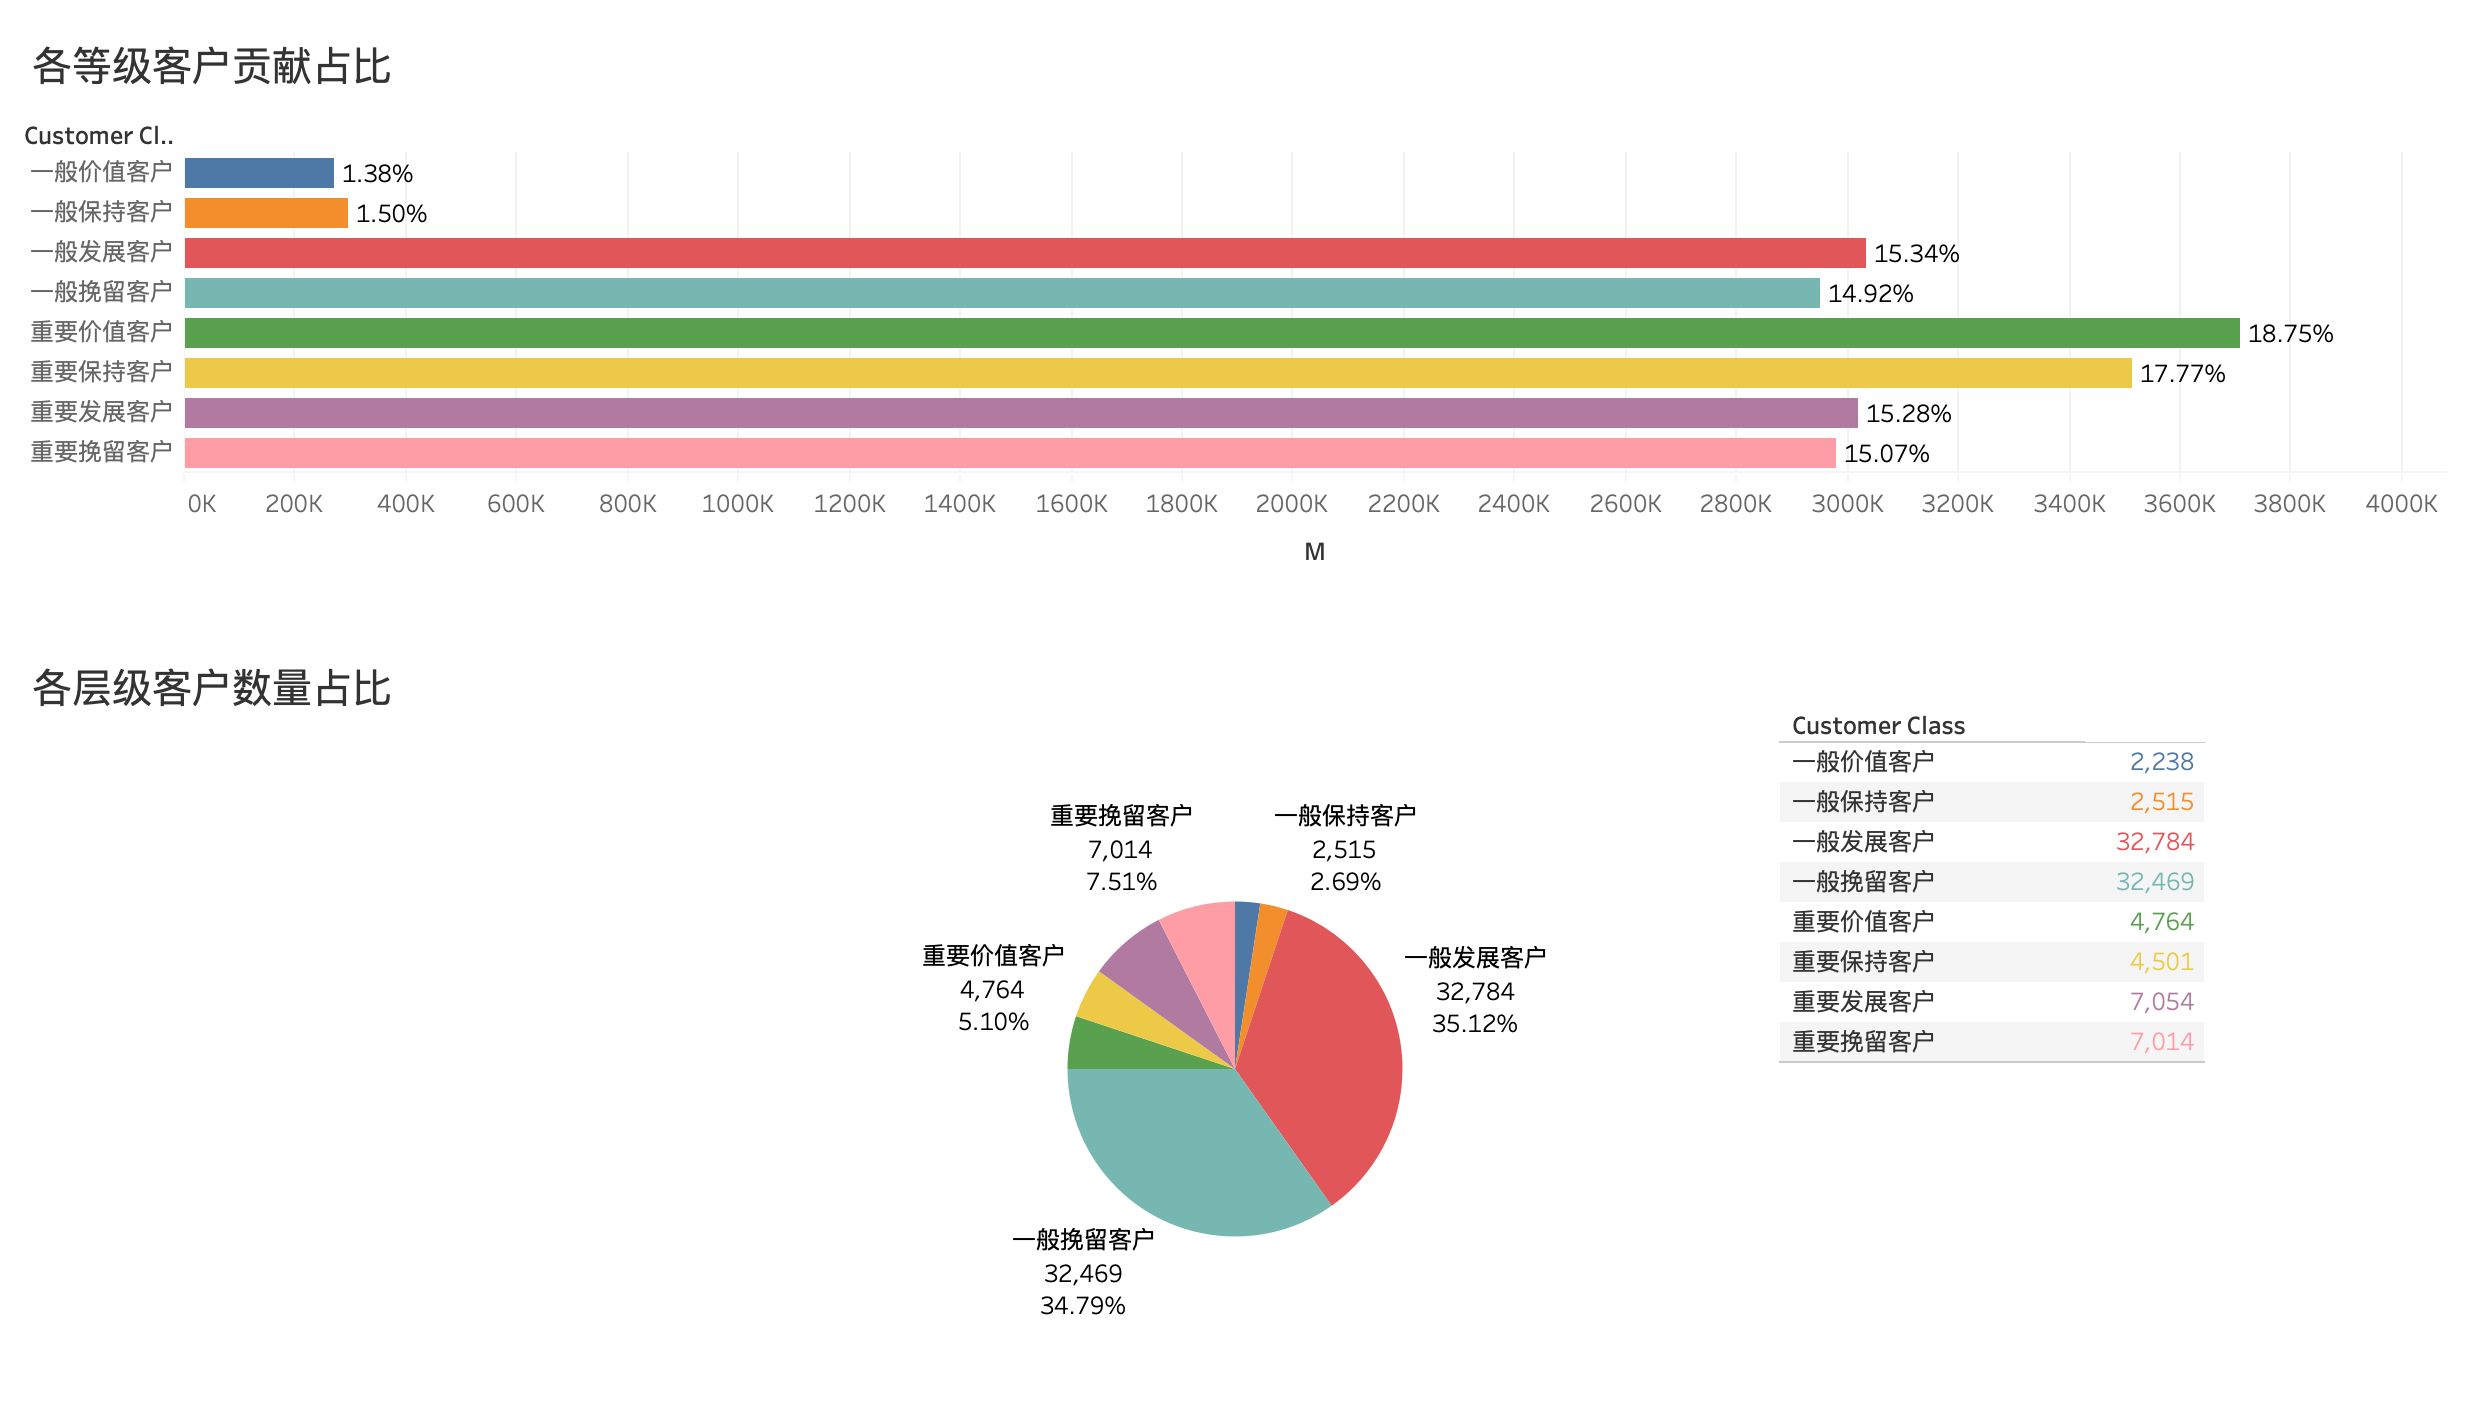

### 分析视角:人-平台
- 分析对象：电商平台
- 分析模块：满意度调查
  - 参与满意度调查的顾客数
  - 顾客满意度评分占比
  - 顾客满意度调查完成天数
  - 顾客满意度调查填写时间段


### 模块一:满意度调查
### 处理数据
### 合并相关数据集

根据需要分析的指标，选定对应表和数据集，并进行合并



In [88]:
# 合并数据集
review_data = pd.merge(basic_data,reviews, on = 'order_id',how = 'left')
review_data = review_data[['order_id','customer_unique_id','order_purchase_timestamp','review_id','review_score','review_creation_date','review_answer_timestamp']]
review_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115708 entries, 0 to 115707
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  115708 non-null  object        
 1   customer_unique_id        115708 non-null  object        
 2   order_purchase_timestamp  115708 non-null  datetime64[ns]
 3   review_id                 115708 non-null  object        
 4   review_score              115708 non-null  int64         
 5   review_creation_date      115708 non-null  object        
 6   review_answer_timestamp   115708 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 7.1+ MB


### 清洗数据集

In [89]:
# 预览数据集
review_data.head()

,order_id,customer_unique_id,order_purchase_timestamp,review_id,review_score,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,8d5266042046a06655c8db133d120ba5,4,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18 00:00:00,2018-08-22 19:07:58


In [98]:
# 统计缺失值数量和占比
review_data.isnull().sum()

order_id                    0
customer_unique_id          0
order_purchase_timestamp    0
review_id                   0
review_score                0
review_creation_date        0
review_answer_timestamp     0
dtype: int64

无缺失值

In [99]:
# 观察数据异常情况
review_data.describe()

,review_score
count,115708.000000
mean,4.065086
std,1.359622
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [100]:
# 查看数据信息
review_data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115708 entries, 0 to 115707
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  115708 non-null  object        
 1   customer_unique_id        115708 non-null  object        
 2   order_purchase_timestamp  115708 non-null  datetime64[ns]
 3   review_id                 115708 non-null  object        
 4   review_score              115708 non-null  int64         
 5   review_creation_date      115708 non-null  object        
 6   review_answer_timestamp   115708 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 7.1+ MB


In [102]:
# 查看每一行数据是否存在重复值
review_data.duplicated().sum()
# 查看重复数据
review_data[review_data.duplicated() == True]

,order_id,customer_unique_id,order_purchase_timestamp,review_id,review_score,review_creation_date,review_answer_timestamp
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48
11,e69bfb5eb88e0ed6a785585b27e16dbf,299905e3934e9e181bfb2e164dd4b4f8,2017-07-29 11:55:02,abc5655186d40772bd6e410420e6a3ed,5,2017-08-17 00:00:00,2017-08-18 01:47:32
13,e6ce16cb79ec1d90b1da9085a6118aeb,f2a85dec752b8517b5e58a06ff3cd937,2017-05-16 19:41:10,15898b543726a832d4137fbef5d1d00e,1,2017-05-30 00:00:00,2017-05-30 23:13:47
23,83018ec114eee8641c97e08f7b4e926f,634f09f6075fe9032e6c19609ffe995a,2017-10-26 15:54:26,219cf59cf889bc85babbd1cd1fe30f2d,4,2017-11-09 00:00:00,2017-11-10 01:06:29
...,...,...,...,...,...,...,...
115696,9115830be804184b91f5c00f6f49f92d,c716cf2b5b86fb24257cffe9e7969df8,2017-10-04 19:57:37,ebd75732b5804e934123d11ec1f11db0,5,2017-10-21 00:00:00,2017-10-23 14:48:40
115697,9115830be804184b91f5c00f6f49f92d,c716cf2b5b86fb24257cffe9e7969df8,2017-10-04 19:57:37,ebd75732b5804e934123d11ec1f11db0,5,2017-10-21 00:00:00,2017-10-23 14:48:40
115698,9115830be804184b91f5c00f6f49f92d,c716cf2b5b86fb24257cffe9e7969df8,2017-10-04 19:57:37,ebd75732b5804e934123d11ec1f11db0,5,2017-10-21 00:00:00,2017-10-23 14:48:40
115700,aa04ef5214580b06b10e2a378300db44,e03dbdf5e56c96b106d8115ac336f47f,2017-01-27 00:30:03,e8995c053d3db2d9c07407efe7de52dd,5,2017-02-08 00:00:00,2017-02-11 12:37:36


In [112]:
review_data = review_data.drop_duplicates()
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96995 entries, 0 to 115707
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96995 non-null  object        
 1   customer_unique_id        96995 non-null  object        
 2   order_purchase_timestamp  96995 non-null  datetime64[ns]
 3   review_id                 96995 non-null  object        
 4   review_score              96995 non-null  int64         
 5   review_creation_date      96995 non-null  datetime64[ns]
 6   review_answer_timestamp   96995 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(3)
memory usage: 5.9+ MB


In [113]:
data = review_data
column_list =['order_purchase_timestamp','review_creation_date','review_answer_timestamp'] 
transform_datetime(data,column_list)

日期时间数据类型转化完成


数据清洗后

- 样本大小：96995 条数据
- 字段：7个
- 无异常值,无缺失值
- 有少量重复值，已删除


In [117]:
# 导出数据库
data = review_data
table_name = 'review_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


In [116]:
data

,order_id,customer_unique_id,order_purchase_timestamp,review_id,review_score,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,8d5266042046a06655c8db133d120ba5,4,2018-08-08,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18,2018-08-22 19:07:58
5,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,359d03e676b3c069f62cadba8dd3f6e8,5,2017-12-03,2017-12-05 19:21:58
6,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,e50934924e227544ba8246aeb3770dd4,5,2018-02-17,2018-02-18 13:02:51
...,...,...,...,...,...,...,...
115702,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,e262b3f92d1ce917aa412a9406cf61a6,5,2017-03-22,2017-03-23 11:02:08
115703,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,29bb71b2760d0f876dfa178a76bc4734,4,2018-03-01,2018-03-02 17:50:01
115704,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,371579771219f6db2d830d50805977bb,5,2017-09-22,2017-09-22 23:10:57
115705,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,8ab6855b9fe9b812cd03a480a25058a1,2,2018-01-26,2018-01-27 09:16:56


### 客户满意度调查情况

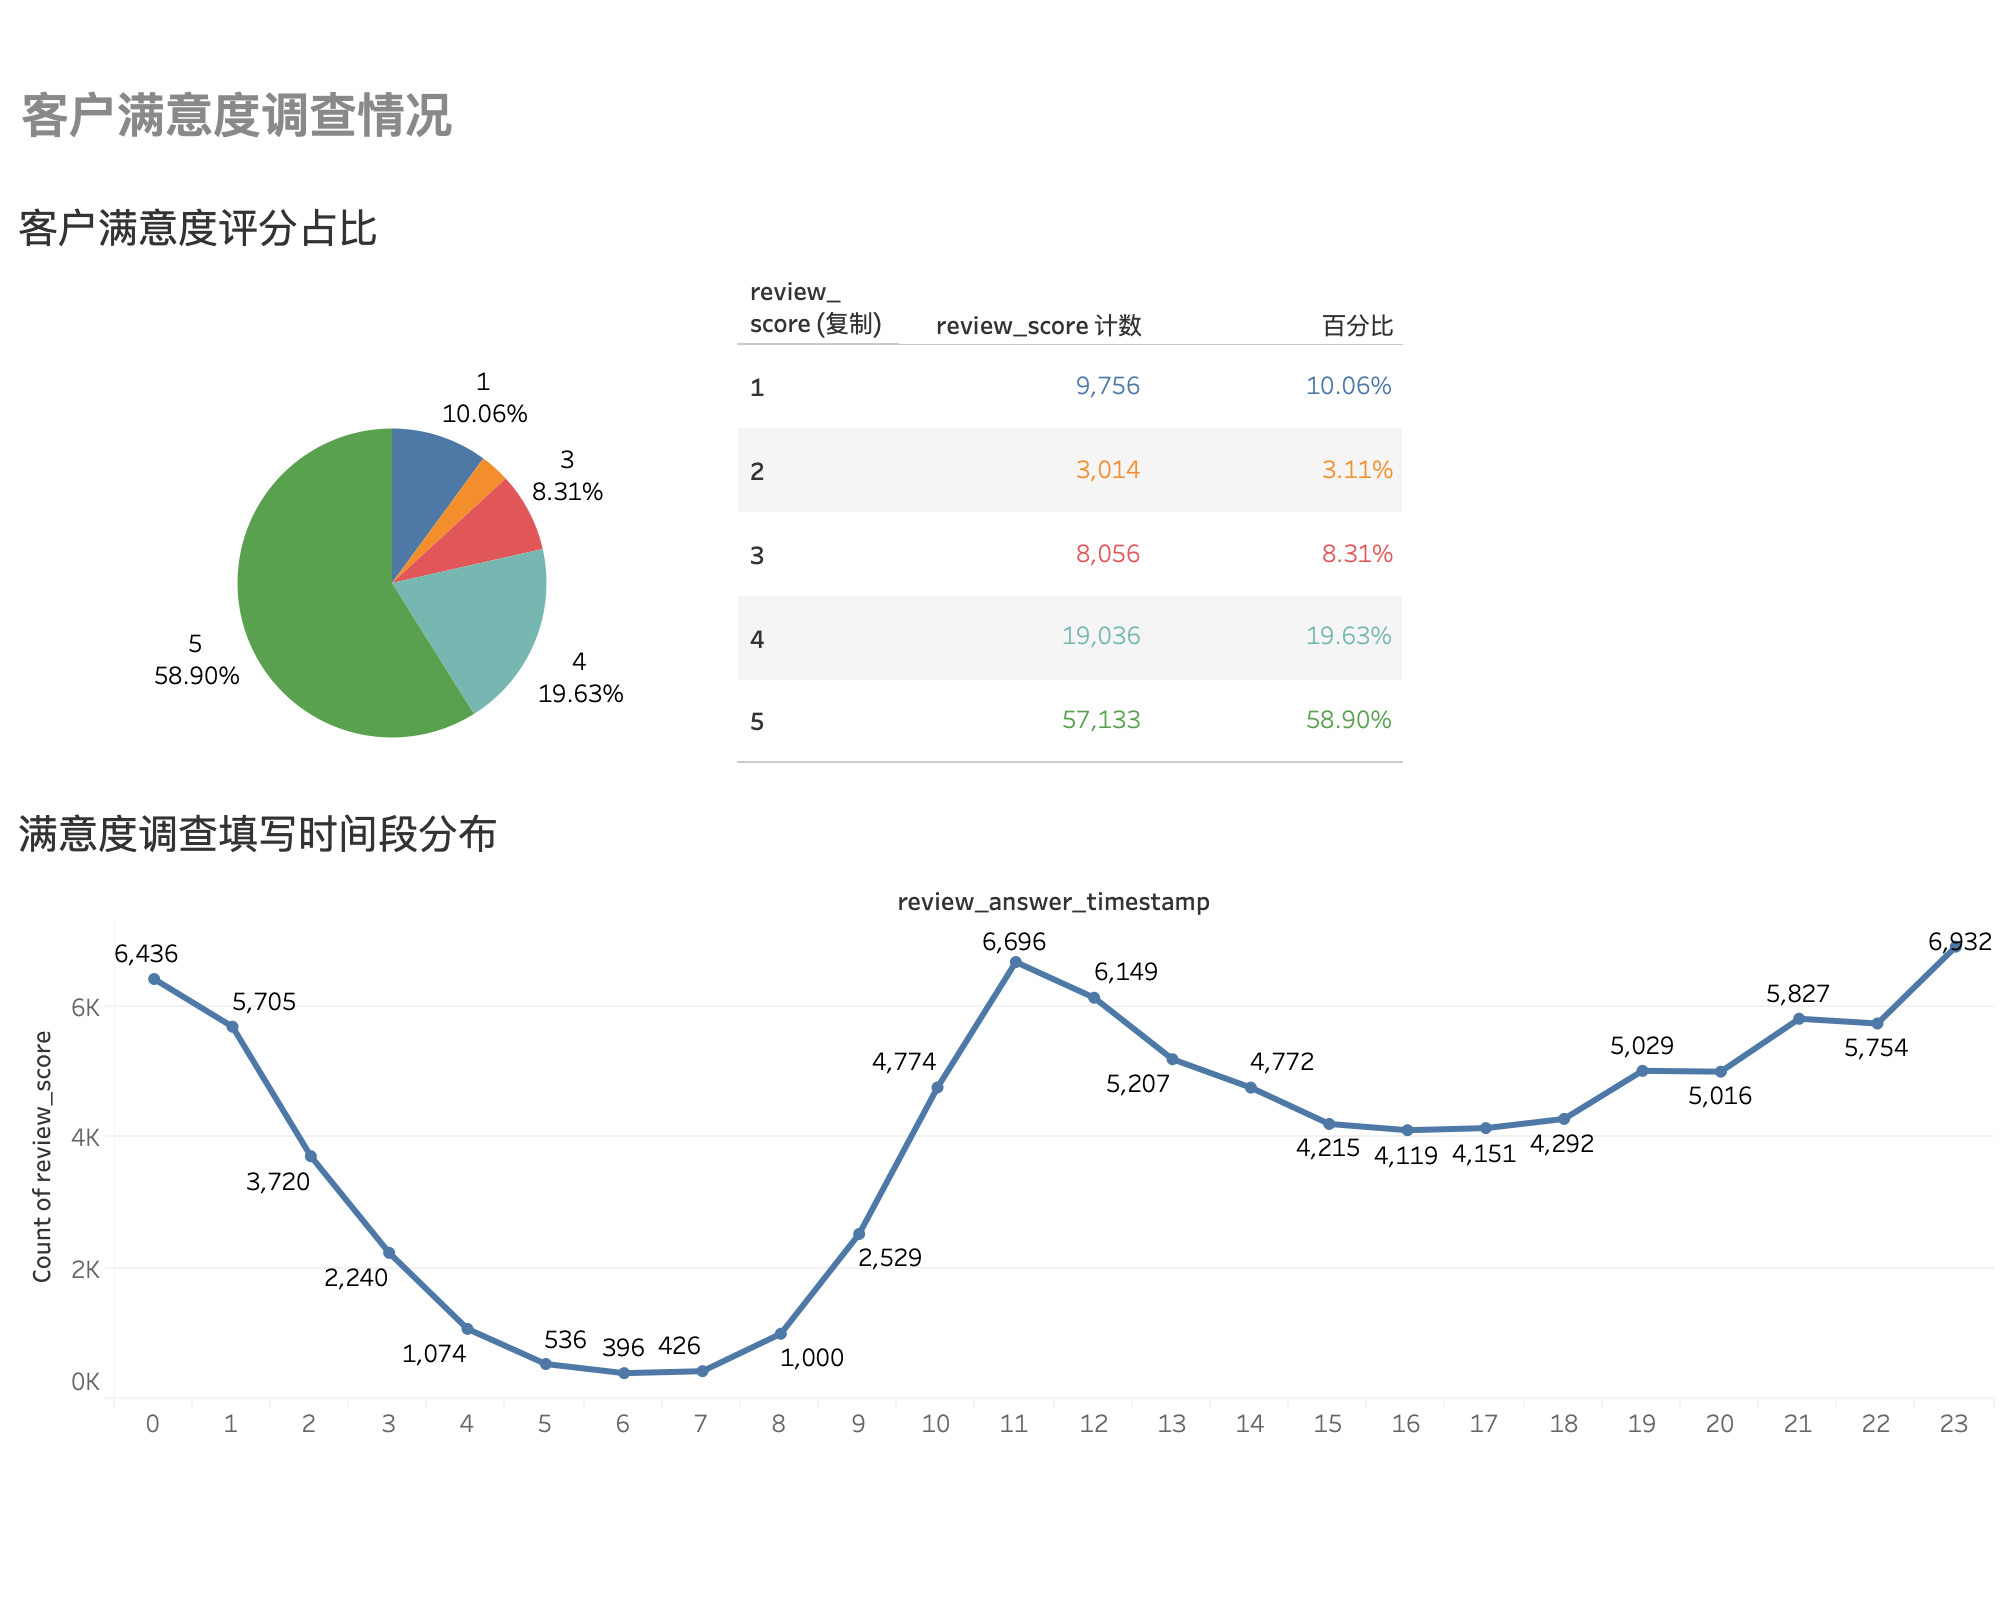

### 客户满意度评分占比
- 客户对该电商平台满意度较高，好评率高达80%。
- 上午10时至下午14时、晚上21时至第二天凌晨1点这两个时间段是客户完成调查的高峰期


### 分析视角:货
- 分析对象：商品
  - 商品、品类销售情况
  - 各品类贡献的销售额分布
  - 根据二八原理划分商品品类


#### 合并相关数据集

In [119]:
# 合并数据集
res = pd.merge(basic_data,products, on='product_id',how='left')
pro_data = pd.merge(res,pro_trans, on='product_category_name',how='left')
print('合并后数据集所有字段\n',pro_data.columns.values)
print('==='*15)

# 选取子集
product_data = pro_data[['order_id','order_item_id','customer_unique_id','product_id','product_category_name_english','price','freight_value','payment_value','order_status','order_purchase_timestamp']]
product_data.info()

合并后数据集所有字段
 ['order_id' 'customer_id' 'order_status' 'order_purchase_timestamp'
 'order_approved_at' 'order_delivered_carrier_date'
 'order_delivered_customer_date' 'order_estimated_delivery_date'
 'payment_sequential' 'payment_type' 'payment_installments'
 'payment_value' 'customer_unique_id' 'customer_zip_code_prefix'
 'customer_city' 'customer_state' 'order_item_id' 'product_id' 'seller_id'
 'shipping_limit_date' 'price' 'freight_value' 'order_date'
 'order_yearmonth' 'product_category_name' 'product_name_lenght'
 'product_description_lenght' 'product_photos_qty' 'product_weight_g'
 'product_length_cm' 'product_height_cm' 'product_width_cm'
 'product_category_name_english']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 115015 entries, 0 to 115014
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115015 non-null  object        

In [120]:
# 预览数据集
product_data.head()

,order_id,order_item_id,customer_unique_id,product_id,product_category_name_english,price,freight_value,payment_value,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,18.12,delivered,2017-10-02 10:56:33
1,e481f51cbdc54678b7cc49136f2d6af7,1.0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,2.00,delivered,2017-10-02 10:56:33
2,e481f51cbdc54678b7cc49136f2d6af7,1.0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,18.59,delivered,2017-10-02 10:56:33
3,53cdb2fc8bc7dce0b6741e2150273451,1.0,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,perfumery,118.70,22.76,141.46,delivered,2018-07-24 20:41:37
4,47770eb9100c2d0c44946d9cf07ec65d,1.0,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,auto,159.90,19.22,179.12,delivered,2018-08-08 08:38:49


In [124]:
# 统计缺失值数量和占比
missing_info(product_data,10)

                               total missing missing percentage
product_category_name_english           1650              1.43%
order_purchase_timestamp                   0              0.00%
order_status                               0              0.00%
payment_value                              0              0.00%
freight_value                              0              0.00%
price                                      0              0.00%
product_id                                 0              0.00%
customer_unique_id                         0              0.00%
order_item_id                              0              0.00%
order_id                                   0              0.00%


缺失值处理：

product_category_name_english 字段缺失值数量为1650，相对其他缺失数据较多，但是与整体数据相比较少,只占 1.43%，可删除缺失值。


In [125]:
# 删除缺失值
product_data = product_data.dropna()
product_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113365 entries, 0 to 115014
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113365 non-null  object        
 1   order_item_id                  113365 non-null  float64       
 2   customer_unique_id             113365 non-null  object        
 3   product_id                     113365 non-null  object        
 4   product_category_name_english  113365 non-null  object        
 5   price                          113365 non-null  float64       
 6   freight_value                  113365 non-null  float64       
 7   payment_value                  113365 non-null  float64       
 8   order_status                   113365 non-null  object        
 9   order_purchase_timestamp       113365 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 9.5+ MB


In [126]:
# 观察数据异常情况
product_data.describe()

,order_item_id,price,freight_value,payment_value
count,113365.000000,113365.000000,113365.000000,113365.000000
mean,1.196851,120.179106,20.024299,172.239539
std,0.701326,182.795481,15.753455,266.631134
min,1.000000,0.850000,0.000000,0.000000
25%,1.000000,39.900000,13.080000,61.000000
50%,1.000000,74.900000,16.320000,108.140000
75%,1.000000,133.740000,21.200000,189.370000
max,21.000000,6735.000000,409.680000,13664.080000


In [127]:
# 查看每一行数据是否存在重复值
product_data.duplicated().sum()


643

In [128]:

# 查看重复数据
product_data[product_data.duplicated() == True]

,order_id,order_item_id,customer_unique_id,product_id,product_category_name_english,price,freight_value,payment_value,order_status,order_purchase_timestamp
387,d7f4e2f755cf2f40aa7c39804cfe01c4,1.0,37d2d1ac62901f9a36cff32ca86c9337,cec09725da5ed01471d9a505e7389d37,sports_leisure,69.90,20.98,30.22,delivered,2017-11-26 12:50:56
1112,92a9ef7f0a0d392c9ad0d5f44e86b4ba,1.0,c375736396906dff8414217e02c45661,9f1c3e71d56894398a42b050b07f1baa,cool_stuff,11.87,7.39,25.00,delivered,2018-03-25 16:43:56
1113,92a9ef7f0a0d392c9ad0d5f44e86b4ba,2.0,c375736396906dff8414217e02c45661,9f1c3e71d56894398a42b050b07f1baa,cool_stuff,11.87,7.39,25.00,delivered,2018-03-25 16:43:56
1114,92a9ef7f0a0d392c9ad0d5f44e86b4ba,3.0,c375736396906dff8414217e02c45661,9f1c3e71d56894398a42b050b07f1baa,cool_stuff,11.87,7.39,25.00,delivered,2018-03-25 16:43:56
1138,06875ab72c5b9bb2eb303a70031bfeb0,1.0,b14edf7220c5c77f27f11567178c24fb,f4c9a2926d5a2fe099ebbe7d0967bd37,fashion_bags_accessories,39.90,7.78,22.68,delivered,2018-01-11 20:04:57
...,...,...,...,...,...,...,...,...,...,...
113816,de06e436fbb3dd6e10bafb5f24ed5530,1.0,a3631b903f909b6749a452358116cf86,418d8bb517562fb8e8a2f1c5de0afa70,computers_accessories,19.90,16.11,9.17,delivered,2017-09-07 01:15:30
113991,5b03dc75d71e4a3940c88c4c9cdf6c2c,1.0,caa8b91f5582eca3d032203ad5a11c32,9af7b4a3262141c12ba9bd489a8573c7,market_place,47.90,18.28,20.00,delivered,2018-04-25 10:40:29
114311,aa61ca4def1d3385bafe461f6ef46faa,1.0,6b46cfed037b73c631cf418c96169857,c708ba7c6269161f89ce0683cdd7c432,watches_gifts,49.00,10.96,53.96,delivered,2017-02-24 20:28:53
114312,aa61ca4def1d3385bafe461f6ef46faa,2.0,6b46cfed037b73c631cf418c96169857,380b4664ba5bb18cc9db78ee6bac3558,watches_gifts,37.00,10.96,53.96,delivered,2017-02-24 20:28:53


In [129]:
# 去重处理

product_data = product_data.drop_duplicates()
product_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112722 entries, 0 to 115014
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112722 non-null  object        
 1   order_item_id                  112722 non-null  float64       
 2   customer_unique_id             112722 non-null  object        
 3   product_id                     112722 non-null  object        
 4   product_category_name_english  112722 non-null  object        
 5   price                          112722 non-null  float64       
 6   freight_value                  112722 non-null  float64       
 7   payment_value                  112722 non-null  float64       
 8   order_status                   112722 non-null  object        
 9   order_purchase_timestamp       112722 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 9.5+ MB


In [130]:
# 转化格式

data = product_data
column_list =['order_purchase_timestamp'] 
transform_datetime(data,column_list)

日期时间数据类型转化完成


数据清洗后

- 样本大小：112722 条数据
- 字段：10个
- 无异常值,无缺失值
- 有少量重复值，已删除

### 导出到 mysql 数据库

In [133]:
# 导出数据库
data = product_data
table_name = 'pro_data'
export_mysql(data,user,password,host_port,db,table_name)

将清洗后的数据导出到 mysql
成功导出


### 商品和品类销售情况

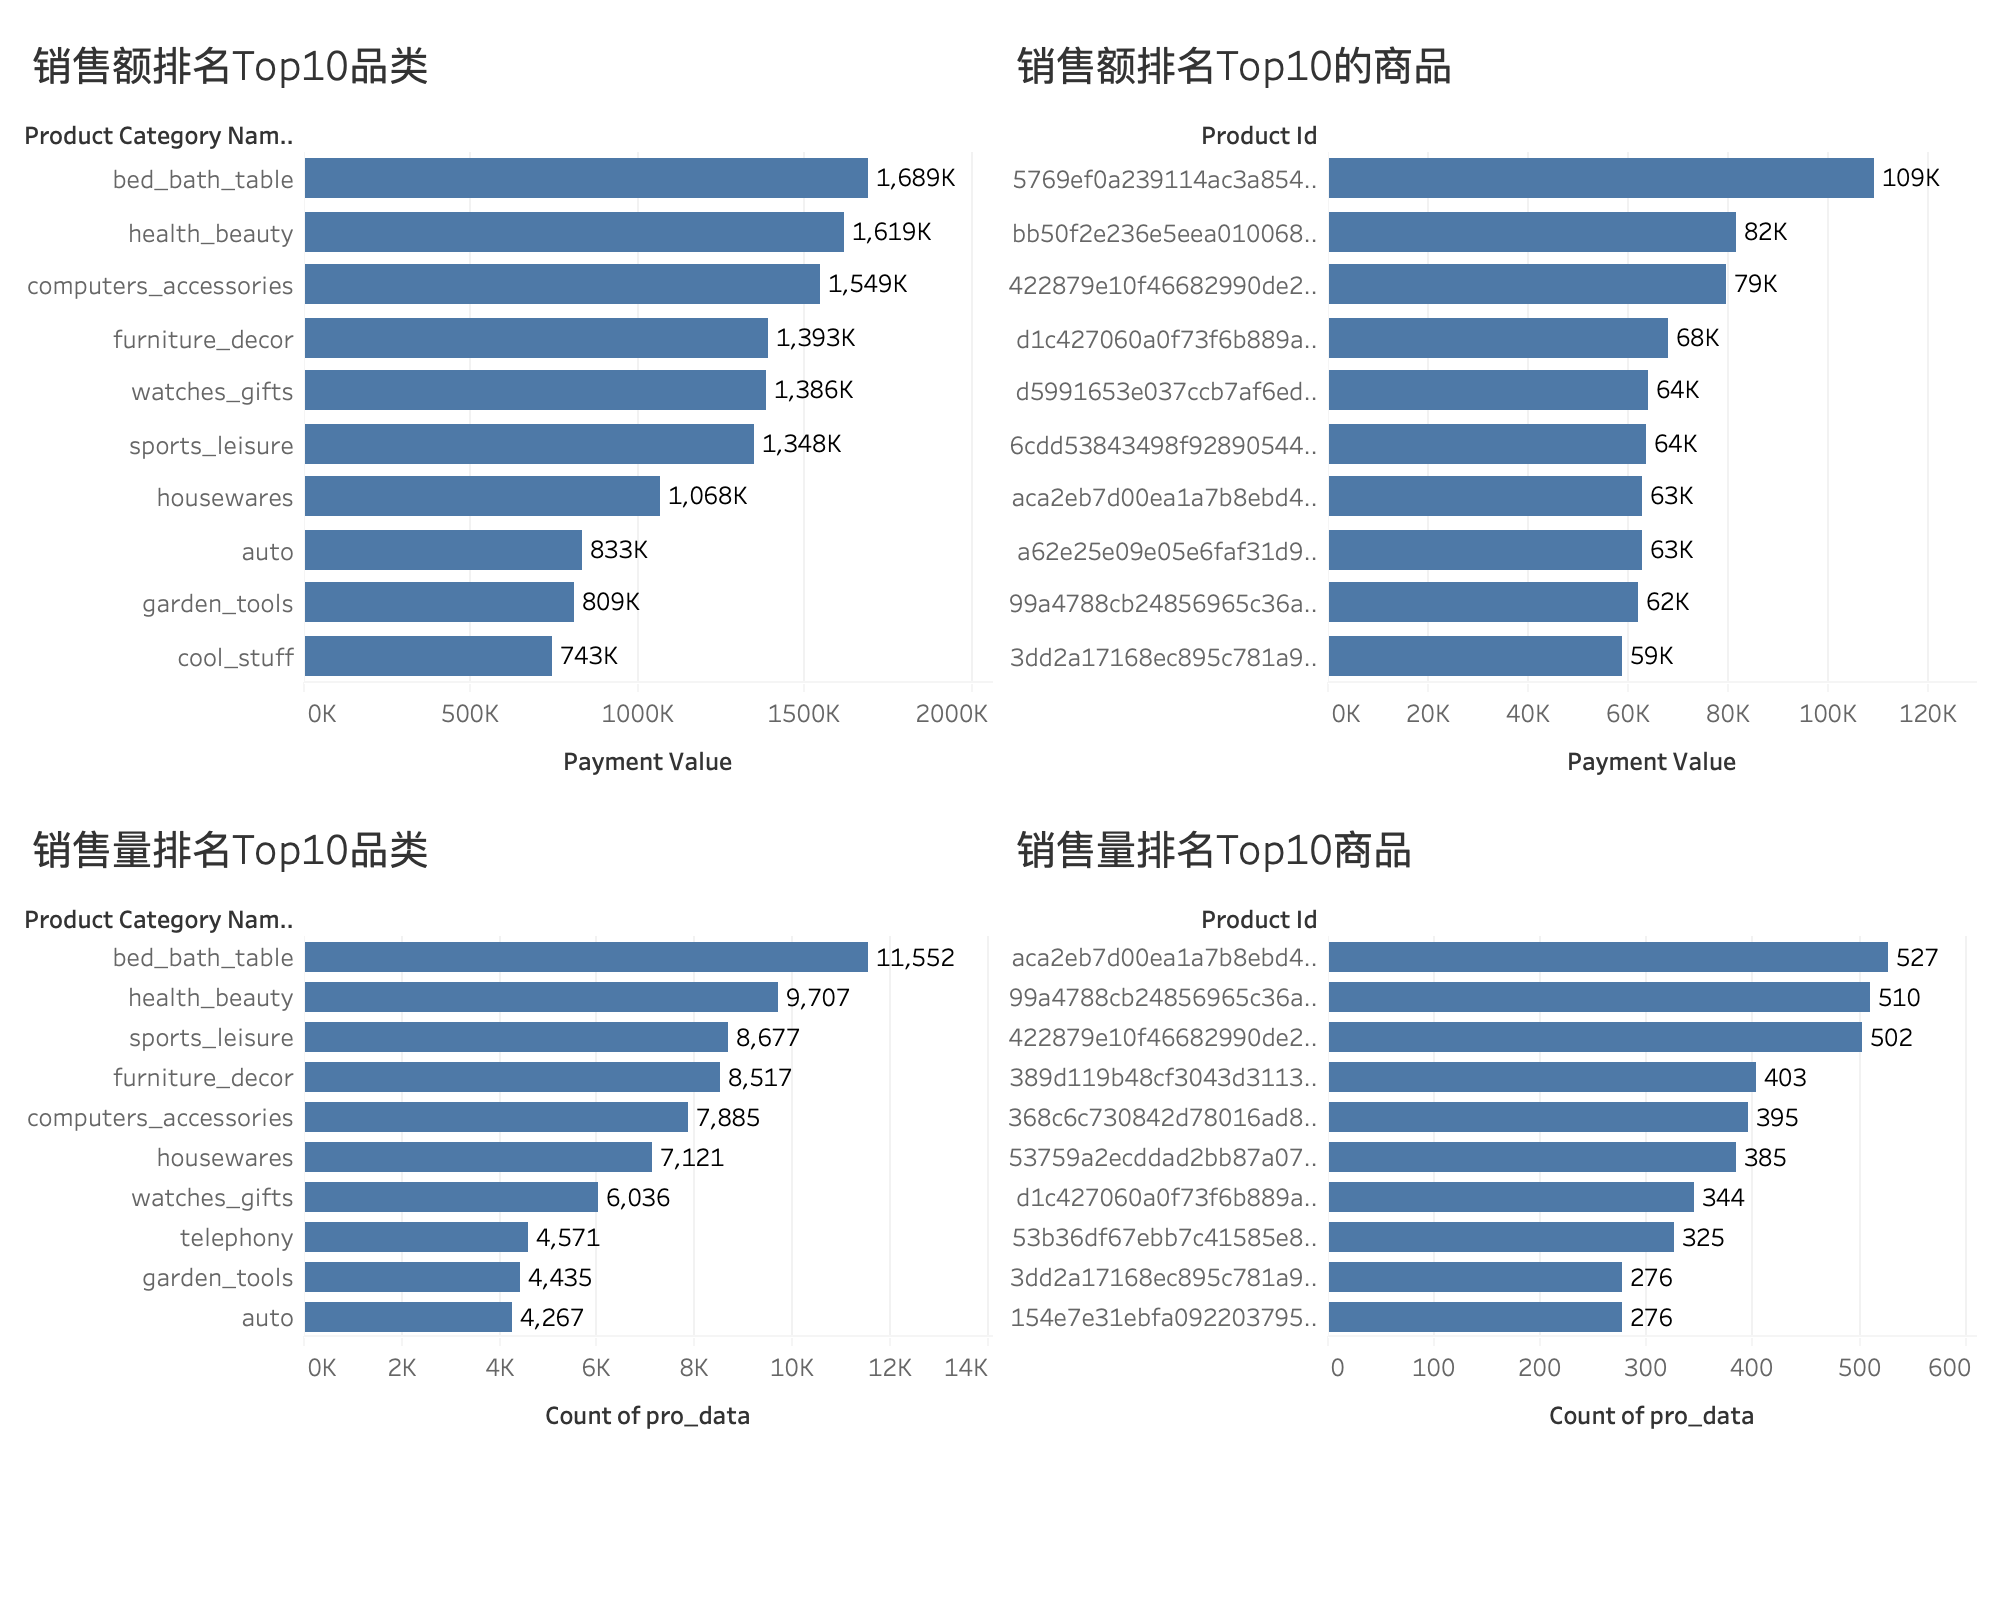

销量和销售额最高的是床上用品、洗漱用品、桌子类的商品。


### 分析视角:场
- 分析对象：订单
  - 销售额
  - 订单量
  - 客单价


### 模块一:交易订单
#### 处理数据

使用 basic_data 构造整体销售情况子数据集 sales_data

In [136]:
# 预览数据集 basic_data
basic_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_date,order_yearmonth
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017-10-02,2017-10
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017-10-02,2017-10
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017-10-02,2017-10
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,2018-07-24,2018-07
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,2018-08-08,2018-08


In [137]:
basic_data ['order_date'] = basic_data['order_purchase_timestamp'].dt.date
basic_data ['order_month']= basic_data['order_purchase_timestamp'].dt.month
basic_data ['order_year'] =basic_data['order_purchase_timestamp'].dt.year

In [138]:
sale_data =  basic_data[['order_date','customer_unique_id','payment_value','order_year','order_month']]

In [139]:
sale_data

,order_date,customer_unique_id,payment_value,order_year,order_month
0,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,18.12,2017,10
1,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,2.00,2017,10
2,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,18.59,2017,10
3,2018-07-24,af07308b275d755c9edb36a90c618231,141.46,2018,7
4,2018-08-08,3a653a41f6f9fc3d2a113cf8398680e8,179.12,2018,8
...,...,...,...,...,...
118429,2018-02-06,da62f9e57a76d978d02ab5362c509660,195.00,2018,2
118430,2017-08-27,737520a9aad80b3fbbdad19b66b37b30,271.01,2017,8
118431,2018-01-08,5097a5312c8b157bb7be58ae360ef43c,441.16,2018,1
118432,2018-01-08,5097a5312c8b157bb7be58ae360ef43c,441.16,2018,1


In [143]:
# 按照年份、月份对销售子数据集进行分组求和、计数，得到订单日期、销售额、客户数、订单量、年份、月份信息

sales_year = sale_data.groupby(['order_year','order_month']).agg({"order_date":"count","payment_value":"sum","customer_unique_id":"nunique"})

sales_year.rename(columns={"order_date":"order_number","payment_value":"total_pay","customer_unique_id":"customer_number"},inplace=True)
sales_year.head(20)


order_number   total_pay  customer_number
order_year order_month                                           
2016       10                    336    62591.65              267
           12                      1       19.62                1
2017       1                     961   176376.56              716
           2                    1949   323815.95             1618
           3                    3078   505735.83             2508
           4                    2707   456108.32             2274
           5                    4260   701119.60             3478
           6                    3687   585400.98             3076
           7                    4726   716069.98             3802
           8                    5053   842689.94             4114
           9                    5002   996085.61             4082
           10                   5455   998609.62             4417
           11                   8812  1548547.86             7182
           12                   6440  1020067.26             5450
2018       1                    8364  1374064.02             6974
           2                    7766  1280014.54             6401
           3                    8337  1435458.33             6914
           4                    8111  1466548.46             6743
           5                    8102  1480407.71             6692
           6                    7318  1285396.78             6058

In [144]:
year_2016 = sales_year.loc[2016,:].copy()
year_2017 = sales_year.loc[2017,:].copy()
year_2018 = sales_year.loc[2018,:].copy()
year_2016    # 看一下2016年的数据

,order_number,total_pay,customer_number
order_month,,,
10,336,62591.65,267
12,1,19.62,1


### 销售额分析
 ####  构建销售额表

In [145]:
# 构建销量表
sales=pd.concat([year_2016['total_pay'],year_2017['total_pay'],
                 year_2018['total_pay']],axis=1)
# 填充 NAN 值为0
sales =sales.fillna(0)

In [146]:
sales

,total_pay,total_pay,total_pay
order_month,,,
1,0.00,176376.56,1374064.02
2,0.00,323815.95,1280014.54
3,0.00,505735.83,1435458.33
4,0.00,456108.32,1466548.46
5,0.00,701119.60,1480407.71
6,0.00,585400.98,1285396.78
7,0.00,716069.98,1306707.42
8,0.00,842689.94,1211240.09
9,0.00,996085.61,0.00


In [148]:
# 对行名和列名进行重命名
sales.columns=['Sales-2016','Sales-2017','Sales-2018']
sales.index=['Jau','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# 颜色越深，销售额越高
sales.style.background_gradient()

,Sales-2016,Sales-2017,Sales-2018
Jau,0.000000,176376.560000,1374064.020000
Feb,0.000000,323815.950000,1280014.540000
Mar,0.000000,505735.830000,1435458.330000
Apr,0.000000,456108.320000,1466548.460000
May,0.000000,701119.600000,1480407.710000
Jun,0.000000,585400.980000,1285396.780000
Jul,0.000000,716069.980000,1306707.420000
Aug,0.000000,842689.940000,1211240.090000
Sep,0.000000,996085.610000,0.000000
Oct,62591.650000,998609.620000,0.000000


结合上图可以看出，只有2017年的数据是整年的，2016和2018都或多或少不完整，所以这里只分析2017年的数据。

#### 2017年整体销售额表现

- 2017年销售额整体呈上升趋势，在11月销售金额达到顶峰，且远高于其他月份，1月销售金额最低，3,5月达到了阶段性的小高峰；

- 总的来说，后半年的表现远好于前半年，而且随着月份的增大，销售额也有明显的增加。

In [149]:
year_2017

,order_number,total_pay,customer_number
order_month,,,
1,961,176376.56,716
2,1949,323815.95,1618
3,3078,505735.83,2508
4,2707,456108.32,2274
5,4260,701119.60,3478
6,3687,585400.98,3076
7,4726,716069.98,3802
8,5053,842689.94,4114
9,5002,996085.61,4082


In [150]:
# 计算环比

for i in range(1,len(year_2017)+1):
    if i == 1:
        year_2017.loc[i,'month_on_month'] = 0
    else:
        year_2017.loc[i,'month_on_month'] = (year_2017.loc[i,'total_pay'] - year_2017.loc[i-1,'total_pay'])/year_2017.loc[i-1,'total_pay']                                                                                                                                       

year_2017[["total_pay","month_on_month"]].style.background_gradient()

,total_pay,month_on_month
order_month,,
1,176376.560000,0.000000
2,323815.950000,0.835935
3,505735.830000,0.561800
4,456108.320000,-0.098129
5,701119.600000,0.537178
6,585400.980000,-0.165048
7,716069.980000,0.223213
8,842689.940000,0.176826
9,996085.610000,0.182031


#### 2017年每月销售额增长率表现
从上面可以看出，2、3、5、11月增速较快，其它月份表现平平

### 订单量分析
 构建订单量表

In [154]:
# 构建订单数量信息表
orders = pd.concat([year_2016['order_number'],year_2017['order_number'],
                 year_2018['order_number']],axis=1)
# 填充 NAN 值为0
orders =orders.fillna(0)
# 对行名和列名进行重命名
orders.columns=['Orders-2016','Orders-2017','Orders-2018']
orders.index=['Jau','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# 颜色越深，订单量越高
orders.style.background_gradient()

,Orders-2016,Orders-2017,Orders-2018
Jau,0.000000,961,8364.000000
Feb,0.000000,1949,7766.000000
Mar,0.000000,3078,8337.000000
Apr,0.000000,2707,8111.000000
May,0.000000,4260,8102.000000
Jun,0.000000,3687,7318.000000
Jul,0.000000,4726,7196.000000
Aug,0.000000,5053,7354.000000
Sep,0.000000,5002,0.000000
Oct,336.000000,5455,0.000000


### 2017年整体订单量表现
从上面可以看出，2017年订单量变化趋势与销售额是一样的，下半年整体高于上半年。

In [163]:
# 计算环比

for i in range(1, len(year_2017)+1):
    if i==1 :
        year_2017.loc[i,'month_on_month'] = 0
    else:
        year_2017.loc[i,'month_on_month'] = (year_2017.loc[i,'order_number'] - year_2017.loc[i-1,'order_number'])/year_2017.loc[i-1,'order_number']       

year_2017 [['order_number','month_on_month']].style.background_gradient()

,order_number,month_on_month
order_month,,
1,961,0.000000
2,1949,1.028096
3,3078,0.579271
4,2707,-0.120533
5,4260,0.573698
6,3687,-0.134507
7,4726,0.281801
8,5053,0.069192
9,5002,-0.010093


#### 2017年每月订单量增长率表现
从上面可以看出，2017年订单量增长率变化与销售额增长率是一样的，2、3、5、11月增速较快，其他月份表现平平。

In [164]:
# 2016-2018年客单价表

aovs=pd.concat([year_2016['total_pay'],year_2016['customer_number'],year_2017['total_pay'],year_2017['customer_number'],
                 year_2018['total_pay'],year_2018['customer_number']],axis=1)
# 对行名和列名进行重命名
aovs.columns=['Sales-2016','customers-2016','Sales-2017','customers-2017','Sales-2018','customers-2018']
aovs.index=['Jau','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# 填充 NAN 值为0
aovs =aovs.fillna(0)

# 颜色越深，销售额越高
aovs.style.background_gradient()

,Sales-2016,customers-2016,Sales-2017,customers-2017,Sales-2018,customers-2018
Jau,0.000000,0.000000,176376.560000,716,1374064.020000,6974.000000
Feb,0.000000,0.000000,323815.950000,1618,1280014.540000,6401.000000
Mar,0.000000,0.000000,505735.830000,2508,1435458.330000,6914.000000
Apr,0.000000,0.000000,456108.320000,2274,1466548.460000,6743.000000
May,0.000000,0.000000,701119.600000,3478,1480407.710000,6692.000000
Jun,0.000000,0.000000,585400.980000,3076,1285396.780000,6058.000000
Jul,0.000000,0.000000,716069.980000,3802,1306707.420000,6097.000000
Aug,0.000000,0.000000,842689.940000,4114,1211240.090000,6310.000000
Sep,0.000000,0.000000,996085.610000,4082,0.000000,0.000000
Oct,62591.650000,267.000000,998609.620000,4417,0.000000,0.000000


In [170]:
# 2017年客单价
aovs_info=pd.concat([year_2016['total_pay']/year_2016['customer_number'],year_2017['total_pay']/year_2017['customer_number'],year_2018['total_pay']/year_2018['customer_number']],axis=1)

# 对行名和列名进行重命名
aovs_info.columns = ['AOV-2016','AOV-2017','AOV-2018']
aovs_info.index = ['Jau','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# 填充 NAN 值为0
aovs_info =aovs_info.fillna(0)
# 颜色越深，客单价越高
aovs_info.style.background_gradient()


,AOV-2016,AOV-2017,AOV-2018
Jau,0.000000,246.335978,197.026673
Feb,0.000000,200.133467,199.971026
Mar,0.000000,201.649055,207.616189
Apr,0.000000,200.575339,217.491986
May,0.000000,201.587004,221.220519
Jun,0.000000,190.312412,212.181707
Jul,0.000000,188.340342,214.319734
Aug,0.000000,204.834696,191.955640
Sep,0.000000,244.019013,0.000000
Oct,234.425655,226.083228,0.000000


#### 2017年每月客单价趋势
结合上面两图，可知
每月的消费人数呈不断上升趋势，但是客单价总体浮动范围不是很大，稳定在200左右


### 结尾

本文分别人、货、场这三个视角入手一家巴西电商的销售、商品、客户情况，并根据分析结果给出一些有利于拓展客户、提升销量的办法。

### 建议：
1. 对需求旺盛的品类保持并进一步丰富，同时对畅销的头部产品进行分析，发掘用户需求特性，对商城的产品进行结构性优化。
2. 在购买旺盛的月份以及每天当中的时段，可以采取折扣券，包邮等优惠形式吸引用户消费。
3. 通过产品组合，满减等措施提高客单价。
4. 交易额排前的核心城市和州需重点维护，同时对排后的城市和州进行重点发掘，对不同重要程度的城市和州采取不同的营销策略。
5. 对卖家核心的城市和州加快物流建设，打造电子商务的核心区域，同时在卖家集中的区域进一步完善供应链建设，降低产品成本，提高电子商务的价格优势。